## Imports

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

## Set Seed

In [2]:
SEED = 42

## Load Data

In [3]:
RAW_DATA_PATH = os.path.normpath(os.path.join("..", "data", "raw"))
true_raw_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "True.csv"))
false_raw_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "Fake.csv"))

In [4]:
true_raw_data.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true_raw_data.shape

(21417, 4)

In [6]:
false_raw_data.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
false_raw_data.shape

(23481, 4)

## Checking the Data

### Check for Missing Values

There are no missing values in both the true and false data.

In [8]:
true_raw_data.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
false_raw_data.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### Check Text Length

#### Visualise Distributions of Text Length

In [10]:
def plot_answer_lengths(df):
    df = df.copy(deep=True)
    df["text_length"] = df["text"].apply(lambda text: len(text.split()))

    plt.figure(figsize=(15, 10))

    sns.histplot(
        data=df,
        x="text_length",
        bins=70
    )

    plt.title("Histogram of Text Length")
    plt.xlabel("Text Length")
    plt.show()

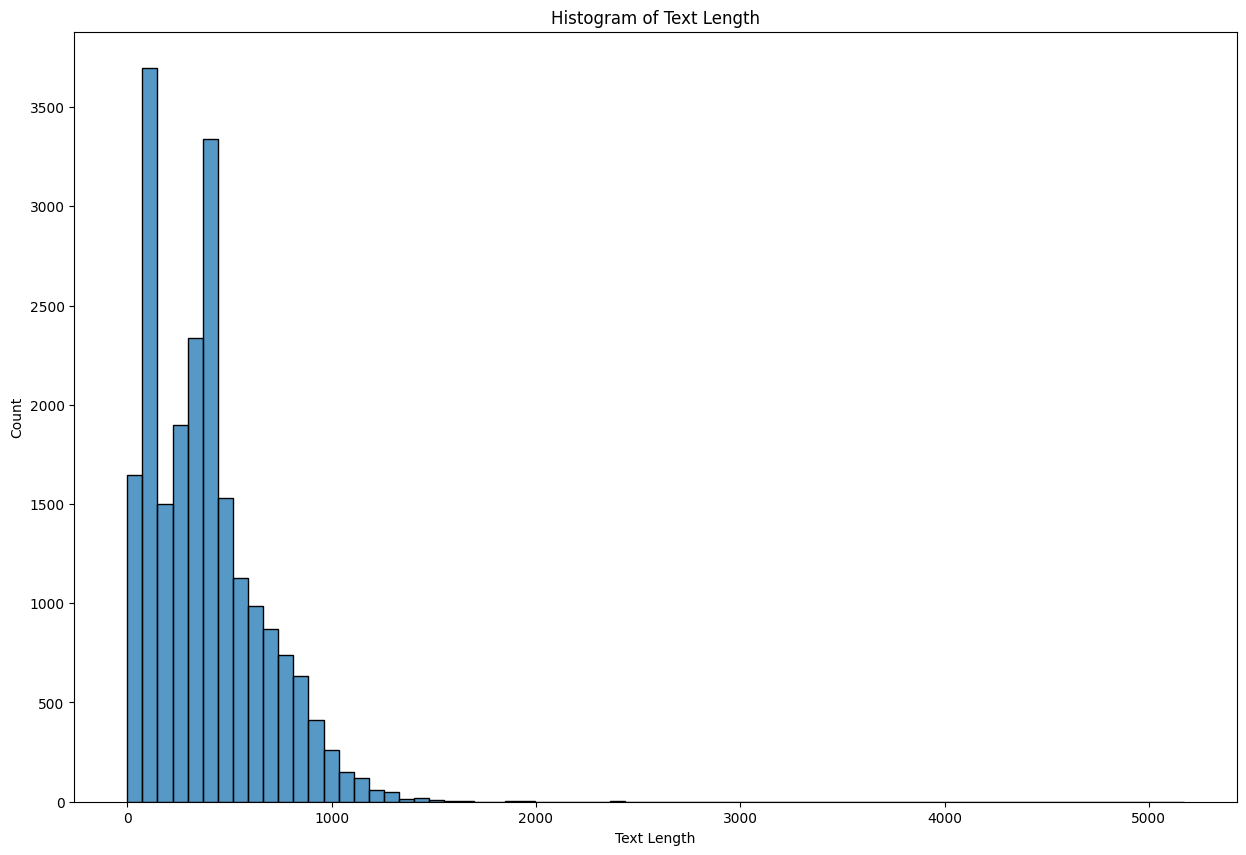

In [11]:
plot_answer_lengths(true_raw_data)

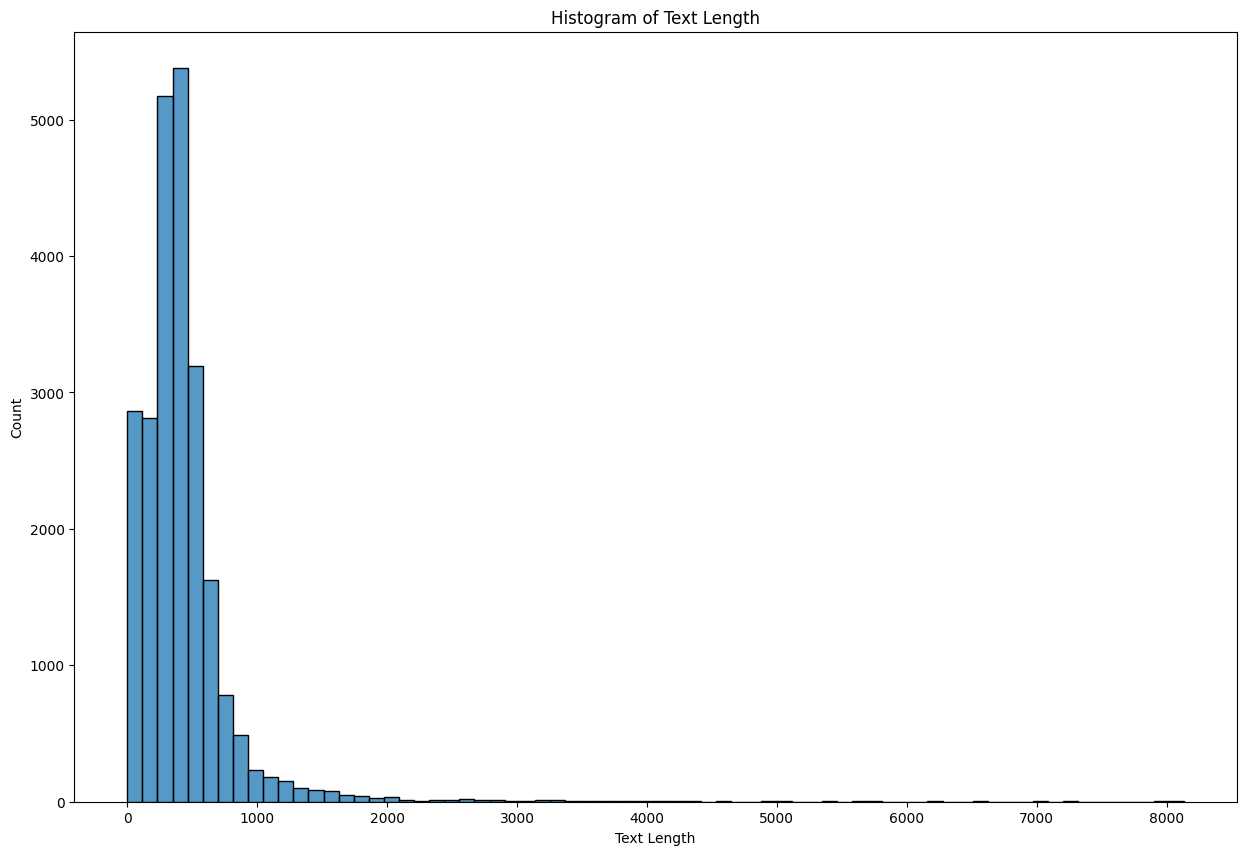

In [12]:
plot_answer_lengths(false_raw_data)

#### Check for Abnormally Short Texts

We are to remove rows corresponding to abnormally short texts - the amount of meaningful information contained within these texts is insufficient.

In [13]:
def find_short_texts(df, min_text_length):
    df = df.copy(deep=True)
    df["text_length"] = df["text"].apply(lambda x: len(x.split()))
    df_short_texts = df[df["text_length"] < min_text_length]
    return df_short_texts.drop(["text_length"], axis=1)

In [14]:
MIN_TEXT_LENGTH = 10       # In terms of approximate number of words (separated by spaces)

In [15]:
find_short_texts(df=true_raw_data, min_text_length=MIN_TEXT_LENGTH)

,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [16]:
find_short_texts(df=false_raw_data, min_text_length=MIN_TEXT_LENGTH)

,title,text,subject,date
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11117,MY FAVORITE EXCUSES…Featuring Hillary Rotten C...,Enjoy:,politics,"Apr 17, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
...,...,...,...,...
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"
21882,ONLY IN DETROIT: SQUATTING ON THE SQUATTER TAK...,You won t want to miss this,left-news,"Apr 9, 2015"


### Common Patterns

Note that out of 21417 rows of the true data, 21246 rows contain the Reuters citation (in the form "(Reuters) -"), typically occurring at the start of the article. These citations reveal the common source of all the true news articles, which unfairly presents a strong indication of truthness to the model. To prevent the model from merely learning how to identify an article's truthness from the citations themselves, we shall remove these citations during cleaning.

In [17]:
true_raw_data_with_reuters_citation = true_raw_data[true_raw_data["text"].str.contains("(Reuters) -", regex=False)]

In [18]:
true_raw_data_with_reuters_citation.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [19]:
true_raw_data_with_reuters_citation.shape

(21246, 4)

Out of 23481 rows of the false data, 733 rows contain the phrase "21st Century Wire says". This phrase typically occurs right before the main body of the article. Note that 21st Century Wire is an alternative news platform.

The presence of this phrase can be attributed to web-crawling inaccuracies during the data retrieval process, causing the actual source of the article to be revealed. This unfairly presents a strong indication of falseness to the model. To prevent the model from merely learning how to identify an article's falseness from this given phrase alone, we shall remove all occurrences of "21 Century Wire says" during cleaning.

In [20]:
false_raw_data_with_21wire_citation = false_raw_data[false_raw_data["text"].str.contains("21st Century Wire says", regex=False)]

In [21]:
false_raw_data_with_21wire_citation.head(5)

,title,text,subject,date
21923,US Advising Soldiers to Be ‘Less Masculine’ as...,"170619-N-AA175-092..SAN DIEGO (June 19, 2017) ...",US_News,"December 29, 2017"
21930,COLLUSION FUSION: DOJ Official’s CIA Wife Was ...,21st Century Wire says More evidence of collus...,US_News,"December 14, 2017"
21935,CIA’s Pompeo: ‘Assange Shouldn’t Be Confident ...,CIA appointed head Mike Pompeo is now ready to...,US_News,"December 5, 2017"
21939,U.S. State Dept. Spox: ‘Everybody wants Assad ...,21st Century Wire says At Tuesday s U.S. State...,US_News,"November 30, 2017"
21940,Facebook’s New ‘Proactive’ AI to Scan Posts fo...,21st Century Wire says Facebook is rolling out...,US_News,"November 28, 2017"


In [22]:
false_raw_data_with_21wire_citation.shape

(733, 4)

### Data Cleaning

In [23]:
def remove_citation_if_present(text, citation):
    if citation in text:
        return text.split(citation)[1]
    
    return text

def clean_true_data(true_df, min_text_length):
    true_df = true_df.copy(deep=True)

    # Remove Reuters citation, as well as any text before the citation
    # Also, remove whitespace from the result
    true_df["text"] = true_df["text"].apply(
        lambda text: remove_citation_if_present(text=text, citation="(Reuters) -").strip()
    )

    # Remove short texts
    true_df["text_length"] = true_df["text"].apply(lambda text: len(text.split()))
    true_df = true_df[true_df["text_length"] >= min_text_length]

    # Remove duplicated rows
    true_df = true_df.drop_duplicates(subset=["text"])

    # Drop columns
    true_df = true_df.drop(["title", "subject", "date", "text_length"], axis=1)

    # Add true label (0)
    true_df["labels"] = 0

    return true_df

def clean_false_data(false_df, min_text_length):
    false_df = false_df.copy(deep=True)

    # Remove 21Wire citation, as well as any text before the citation
    false_df["text"] = false_df["text"].apply(
        lambda text: remove_citation_if_present(text=text, citation="21st Century Wire says")
    )

    # Remove short texts
    false_df["text_length"] = false_df["text"].apply(lambda text: len(text.split()))
    false_df = false_df[false_df["text_length"] >= min_text_length]

    # Remove duplicated rows
    false_df = false_df.drop_duplicates(subset=["text"])

    # Drop columns
    false_df = false_df.drop(["title", "subject", "date", "text_length"], axis=1)

    # Add false label (1)
    false_df["labels"] = 1

    return false_df

In [24]:
true_clean_data = clean_true_data(true_df=true_raw_data, min_text_length=MIN_TEXT_LENGTH)
false_clean_data = clean_false_data(false_df=false_raw_data, min_text_length=MIN_TEXT_LENGTH)

In [25]:
true_clean_data.head(5)

,text,labels
0,The head of a conservative Republican faction ...,0
1,Transgender people will be allowed for the fir...,0
2,The special counsel investigation of links bet...,0
3,Trump campaign adviser George Papadopoulos tol...,0
4,President Donald Trump called on the U.S. Post...,0


In [26]:
true_clean_data.shape

(21189, 2)

In [27]:
false_clean_data.head(5)

,text,labels
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [28]:
false_clean_data.shape

(17292, 2)

## Sampling Data

Due to computational constraints, we will only sample a subset of the true and false data.

In [29]:
NUM_ROWS_SAMPLED = 5000   # For each of true and false data

In [30]:
true_clean_data_sampled = true_clean_data.sample(NUM_ROWS_SAMPLED, random_state=SEED)
false_clean_data_sampled = false_clean_data.sample(NUM_ROWS_SAMPLED, random_state=SEED)
clean_data_sampled = pd.concat([true_clean_data_sampled, false_clean_data_sampled], ignore_index=True)

In [31]:
clean_data_sampled.shape

(10000, 2)

## Split Data

In [32]:
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1

In [33]:
# Get features and labels
X, y = clean_data_sampled.drop(["labels"], axis=1), clean_data_sampled["labels"]

# Split train from val and test
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, stratify=y, random_state=SEED
)

# Split val and test
test_size_wrt_remaining = TEST_SIZE / (1 - TRAIN_SIZE)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=test_size_wrt_remaining, stratify=y_val_test, random_state=SEED
)

# Obtain final train and test data frames
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [34]:
train_df["labels"].value_counts()

labels
0    4000
1    4000
Name: count, dtype: int64

In [35]:
val_df["labels"].value_counts()

labels
1    500
0    499
Name: count, dtype: int64

In [36]:
test_df["labels"].value_counts()

labels
0    501
1    500
Name: count, dtype: int64

## Save Data

In [37]:
PROCESSED_DATA_PATH = os.path.normpath(os.path.join("..", "data", "processed"))
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
train_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "train.csv"), index=False)
val_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "val.csv"), index=False)
test_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "test.csv"), index=False)